In [1]:
import numpy as np
import os

def save_data(*arrays, folder="saved_data"):
    os.makedirs(folder, exist_ok=True)  # Create the folder if it doesn't exist
    filenames = [
        "train_set_branch_y.npy", "train_set_branch_t.npy", "train_set_trunk.npy",
        "branch_mask.npy", "test_truth.npy","samples.npy","samples_noisy.npy"
    ]
    for array, filename in zip(arrays, filenames):
        np.save(os.path.join(folder, filename), array)
    print("Data saved successfully.")

def load_data(folder="saved_data"):
    filenames = [
        "train_set_branch_y.npy", "train_set_branch_t.npy", "train_set_trunk.npy",
        "branch_mask.npy", "test_truth.npy","samples.npy","samples_noisy.npy"

    ]
    arrays = [np.load(os.path.join(folder, filename), allow_pickle=True) for filename in filenames]
    print("Data loaded successfully.")
    return arrays
grid_size = 640
temporal_size = 20

In [249]:
import random
import torch
import torch.nn.functional as F
import numpy as np
from scipy.stats import beta as beta_dist  # Import with a different name
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def prepare_data(num_functions,grid_size):
    # Parameters
      # Total number of functions to generate
    batch_size = 1000         # Batch size for processing
    
    def periodic_kernel_matrix(X, length_scale=1.0, variance=1.0, p=0.1):
  
        X = np.asarray(X).reshape(-1, 1)
        abs_diff = np.abs(X - X.T)
        sin_squared = np.sin(np.pi * abs_diff / p) ** 2
        K = variance * np.exp(-2 * sin_squared / length_scale**2)
        return K

    def rbf_kernel_matrix(X, length_scale=1.0, variance=1.0):
        """
        Compute the RBF kernel matrix for input array X.
        """
        # Compute pairwise squared distances
        X = X.reshape(-1, 1)
        sqdist = np.sum(X**2, axis=1).reshape(-1, 1) + \
                np.sum(X**2, axis=1) - 2 * np.dot(X, X.T)
        K = variance * np.exp(-0.5 * sqdist / length_scale**2)
        return K
    def locally_periodic_kernel_matrix(X, length_scale=1.0, variance=1.0, p=0.1):

        X = np.asarray(X).reshape(-1, 1)    
        abs_diff = np.abs(X - X.T)    
        sin_squared = np.sin(np.pi * abs_diff / p) ** 2    
        k_per = variance * np.exp(-2 * sin_squared / length_scale**2)
        
        sq_diff = (X - X.T) ** 2
        

        k_se = np.exp(-sq_diff / (2 * length_scale**2))
        
        K = k_per * k_se
        
        return K

    def linear_kernel_matrix(X, variance=1.0):
        X = X.reshape(-1, 1)
        K = variance * np.dot(X, X.T)
        return K
    
    def linear_plus_periodic_kernel_matrix(X, lin_variance=1.0, per_length_scale=1.0, per_variance=1.0, p=0.1):
        K_lin = linear_kernel_matrix(X, variance=lin_variance)
        K_per = periodic_kernel_matrix(X, length_scale=per_length_scale, variance=per_variance, p=p)
        return K_lin + K_per 
    def get_kernel(X,l,v,p):
        import random
        r = random.uniform(0, 1)
        if r <0.2:
            return periodic_kernel_matrix(X,l,v,p)
        elif r >=.2 and r <.4:
            return rbf_kernel_matrix(X,l,v)
        elif r >=.4 and r <.6:
            return locally_periodic_kernel_matrix(X,l,v,p)
        elif r >=.6 and r <.8:
            return linear_kernel_matrix(X,v)
        elif r >=.8 and r <=1:
            return linear_plus_periodic_kernel_matrix(X,v,l,v,p)
    


    variance = 1.0           # Variance parameter σ²
    min = 40
    max = 80
    # Create input grid
    X = np.linspace(0, 1, grid_size)  # Points in [0, 1]


    train_set_branch_y_collection = []
    train_set_branch_t_collection = []

    train_set_trunk_collection = []
    branch_mask_collection = []
    trunk_mask_collection = []
    test_truth_collection = []

    samples_ = []
    samples_noisy_ = []

    for j in range(num_functions):

        alpha, beta_param = np.random.choice([1.0,2.0,5.0], 1,replace=False)[0],np.random.choice([1.0,2.0,5.0], 1,replace=False)[0]

        if j % 1000 == 0:
            print(j)
        l,p = beta_dist.rvs(alpha, beta_param),beta_dist.rvs(alpha, beta_param)
        K = get_kernel(X,l,variance,p)

        mean = np.zeros(grid_size)
        noise_std = np.abs(np.random.normal(0, 0.1))

        samples = np.random.multivariate_normal(mean, K, size=1).reshape(-1)
        samples_noisy = samples.copy() + np.random.normal(0, noise_std, size=grid_size)

        samples = samples.reshape(5,-1)
        samples_noisy = samples_noisy.reshape(5,-1)

        train_set_branch_y = np.zeros(shape=(5, grid_size//5))
        train_set_branch_t = np.zeros(shape=(5, grid_size//5))
        test_truth = np.zeros(shape=(5, grid_size//5))

        stats = np.zeros(shape=(5, 12))


        branch_mask = np.zeros(shape=(5, grid_size//5))

        train_set_trunk_t = X.copy().reshape(5,grid_size//5)

        shape = samples_noisy.shape[0]
        for i in range(0,shape):
            r = random.randint(min, max)

            if False:#i < num_functions/2: 
                indices = (np.random.choice(np.arange(0, grid_size), r, replace=False))
            else:
                indices = np.arange(0, grid_size//5)[::random.randint(2, 4)]
      
            y_observed = samples_noisy[i][indices]
            y_truth = samples[i]
            t_truth =X.reshape(5,grid_size//5)[i]
            t_observed = X.reshape(5,grid_size//5)[i][indices]

            y_min,y_max,y_range,y_f,y_l,y_d = (np.min(y_truth),np.max(y_truth),
                                               np.max(y_truth)-np.min(y_truth),
                                               y_truth[0], y_truth[-1],
                                               y_truth[-1] - y_truth[0])

            t_min,t_max,t_range,t_f,t_l,t_d = (np.min(t_truth),np.max(t_truth),
                                               np.max(t_truth) - np.min(t_truth),
                                               t_truth[0],t_truth[-1],
                                               t_truth[-1] - t_truth[0])  
            
             #norm
            y_observed = (y_observed - y_min)/(y_max-y_min)
            y_truth =  (y_truth - y_min)/(y_max-y_min)
            t_observed = (t_observed - t_min)/(t_max-t_min)
            t_truth = (t_truth - t_min)/(t_max-t_min)


            train_set_branch_y[i] = np.append(y_observed,np.zeros(grid_size//5 - len(indices)))         
            train_set_branch_t[i] = np.append(t_observed,np.zeros(grid_size//5 - len(indices)))
            train_set_trunk_t[i] = t_truth
            branch_mask[i]  = np.append(np.ones(len(indices)), np.zeros(grid_size//5 - len(indices)))
            test_truth[i] = y_truth
            stats[i] =  np.array([y_min,y_max,y_range,y_f,y_l,y_d,t_min,t_max,t_range,t_f,t_l,t_d])

      
        train_set_branch_y_collection.append(train_set_branch_y)
        train_set_branch_t_collection.append(train_set_branch_t)
        train_set_trunk_collection.append(train_set_trunk_t)
        branch_mask_collection.append(branch_mask)
        test_truth_collection.append(test_truth)
        samples_.append(samples)
        samples_noisy_.append(samples_noisy)

    train_set_branch_y_collection = (np.asarray(train_set_branch_y_collection, dtype=np.float32)).reshape(num_functions*5,-1)
    train_set_branch_t_collection = (np.asarray(train_set_branch_t_collection, dtype=np.float32)).reshape(num_functions*5,-1)
    train_set_trunk_collection = (np.asarray(train_set_trunk_collection, dtype=np.float32)).reshape(num_functions*5,-1)
    branch_mask_collection = (np.asarray(branch_mask_collection, dtype=np.float32)).reshape(num_functions*5,-1)
    test_truth_collection = (np.asarray(test_truth_collection, dtype=np.float32)).reshape(num_functions*5,-1)
    
    samples_ = (np.asarray(samples_, dtype=np.float32)).reshape(num_functions*5,-1)
    samples_noisy_ = (np.asarray(samples_noisy_, dtype=np.float32)).reshape(num_functions*5,-1)


    return (train_set_branch_y_collection,train_set_branch_t_collection, train_set_trunk_collection, branch_mask_collection, test_truth_collection,samples_,samples_noisy_)





In [252]:
grid_size = 640
num_f = 100
data = prepare_data(num_f,grid_size)
save_data(*data)




0
Data saved successfully.


In [254]:
(train_set_branch_y, train_set_branch_t, train_set_trunk_t,
 branch_mask, test_truth,samples,samples_noisy) = load_data()

train_set_branch_y.shape


Data loaded successfully.


(500, 128)

Data loaded successfully.
[0.         0.00787402 0.01574803 0.02362205 0.03149606 0.03937008
 0.04724409 0.05511811 0.06299213 0.07086615 0.07874016 0.08661418
 0.09448819 0.10236221 0.11023622 0.11811024 0.12598425 0.13385826
 0.14173229 0.1496063  0.15748031 0.16535433 0.17322835 0.18110237
 0.18897638 0.19685039 0.20472442 0.21259843 0.22047244 0.22834645
 0.23622048 0.24409449 0.2519685  0.25984251 0.26771653 0.27559054
 0.28346458 0.2913386  0.2992126  0.30708662 0.31496063 0.32283464
 0.33070865 0.33858266 0.3464567  0.35433072 0.36220473 0.37007874
 0.37795275 0.38582677 0.39370078 0.4015748  0.40944883 0.41732284
 0.42519686 0.43307087 0.44094488 0.4488189  0.4566929  0.46456692
 0.47244096 0.48031497 0.48818898 0.496063   0.503937   0.511811
 0.51968503 0.52755904 0.53543305 0.54330707 0.5511811  0.5590551
 0.56692916 0.5748032  0.5826772  0.5905512  0.5984252  0.6062992
 0.61417323 0.62204725 0.62992126 0.63779527 0.6456693  0.6535433
 0.6614173  0.6692913  0.6771653  0.68503

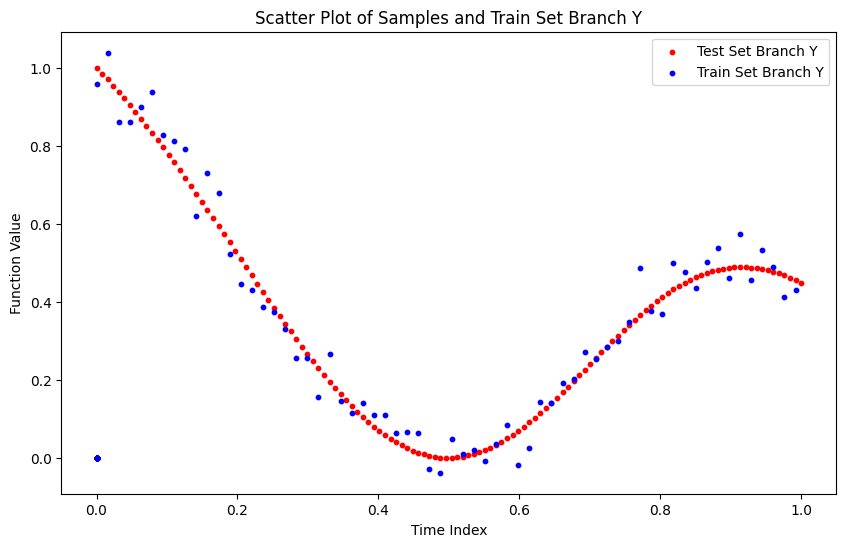

In [273]:
import matplotlib.pyplot as plt

# Daten laden
a = 54

(train_set_branch_y, train_set_branch_t, train_set_trunk_t,
 branch_mask, test_truth, samples, samples_noisy) = load_data()
train_set_branch_y = train_set_branch_y[a]
train_set_branch_t = train_set_branch_t[a]

train_set_trunk_t = train_set_trunk_t[a]
test_truth = test_truth[a]

samples = samples[a]#.reshape(1,-1)


print(train_set_trunk_t)

x = np.linspace(0,1,128) # Assuming samples is a 1D array of length 640

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot 'samples' as blue dots
#plt.scatter(x, samples, color='blue', label='Samples', s=10)  # s=10 sets the marker size

# Plot 'train_set_branch_y' as red dots
plt.scatter(train_set_trunk_t, test_truth, color='red', label='Test Set Branch Y', s=10)
plt.scatter(train_set_branch_t, train_set_branch_y, color='blue', label='Train Set Branch Y', s=10)


# Achsen beschriften und Titel hinzufügen
plt.xlabel('Time Index')
plt.ylabel('Function Value')
plt.title('Scatter Plot of Samples and Train Set Branch Y')

# Add a legend to differentiate the datasets
plt.legend()


# Plot anzeigen
plt.show()

In [81]:


import torch
import torch.nn as nn

class DeepONet(torch.nn.Module):

    def __init__(self, indicator_dim, d_model, heads=1, p=128):
        super(DeepONet, self).__init__()
        self.p = p
        self.branch_embedding_y = nn.Linear(1, d_model)
        self.branch_embedding_t = nn.Linear(1, d_model)
        self.trunk_embedding_t = nn.Linear(1, d_model)
        
        self.embedding_act = nn.Sequential(nn.LayerNorm(d_model),nn.LeakyReLU())
        self.branch_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=d_model, nhead=heads, batch_first=True), num_layers=6, enable_nested_tensor=False)

        self.branch_mlp = nn.Sequential(nn.Linear(indicator_dim*d_model,d_model),nn.LeakyReLU(),
                                        nn.Linear(d_model, self.p),nn.LeakyReLU())  
        
        self.trunk_mlp =   nn.Sequential(nn.Linear(d_model, d_model),nn.LeakyReLU(),
                                         nn.LayerNorm(d_model),
                                         nn.Linear(d_model, d_model),nn.LeakyReLU(),
                                         nn.Linear(d_model, d_model),nn.LeakyReLU(),
                                         nn.LayerNorm(d_model),
                                         nn.Linear(d_model, self.p),nn.LeakyReLU())  
        
      

     #   self.trunk_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=d_model, nhead=heads, batch_first=True), num_layers=4, enable_nested_tensor=False)
  
    def forward(self, y, t, t_sample, y_mask):
        y = y.unsqueeze(-1) * y_mask.unsqueeze(-1)
        t = t.unsqueeze(-1) * y_mask.unsqueeze(-1)
        t_sample = t_sample.unsqueeze(-1)
        branch_embedding_y = self.branch_embedding_y(y)
        branch_embedding_t = self.branch_embedding_t(t)
        trunk_encoder_input = self.trunk_embedding_t(t_sample)

       
        y_mask_enc = torch.where(y_mask == 1, False, True)
      #  t_sample_mask_enc = torch.where(t_sample_mask == 1, False, True)


        branch_encoder_input = self.embedding_act(branch_embedding_y + branch_embedding_t)
        branch_encoder_output = self.branch_encoder(branch_encoder_input, src_key_padding_mask=y_mask_enc)
        #trunk_encoder_output = self.trunk_encoder(trunk_encoder_input, src_key_padding_mask=t_sample_mask_enc)

        branch_encoder_output = branch_encoder_output * y_mask.unsqueeze(-1)
       # trunk_encoder_output = trunk_encoder_output * t_sample_mask.unsqueeze(-1)

        branch_encoder_output = (branch_encoder_output).view(branch_encoder_output.shape[0],-1)

        branch_output = self.branch_mlp(branch_encoder_output) 
        trunk_output = self.trunk_mlp(trunk_encoder_input  ) 

        combined = torch.bmm(branch_output.unsqueeze(1), trunk_output.transpose(1, 2)).squeeze()
        return combined

In [ ]:

import torch.nn.utils as nn_utils
import math
from dataset import TimeSeriesDataset

class InverseSquareRootLR(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_steps, init_lr, min_lr=1e-9, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.init_lr = init_lr
        self.min_lr = min_lr
        super(InverseSquareRootLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        step = self.last_epoch + 1
        if step < self.warmup_steps:
            # Linear warmup
            lr = self.init_lr * (step / self.warmup_steps)
        else:
            # Inverse square root decay
            lr = self.init_lr * math.sqrt(self.warmup_steps / step)

        # Ensure learning rate doesn't go below minimum
        lr = max(lr, self.min_lr)

        return [lr for _ in self.base_lrs]
    

dataset = TimeSeriesDataset(
    train_set_branch_y,
    train_set_branch_t,
    train_set_trunk_t,
    branch_mask,
    test_truth
)
epochs = 20
# Initialize the DataLoader
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)
model = DeepONet(grid_size,d_model=256,heads=2,p=164)

model.to(device)
model.train()

print(f"Params: {sum(p.numel() for p in model.parameters())}")
optim = torch.optim.AdamW(model.parameters(),lr=4.6e-4)
lr_scheduler = InverseSquareRootLR(optim,warmup_steps=200,init_lr=4.6e-4,min_lr=1.916e-5)

loss = 0
for epoch in range(epochs):
    for batch in dataloader:
        train_set_branch_y = batch["train_set_branch_y"].to(device)
        train_set_branch_t = batch["train_set_branch_t"].to(device)

        train_set_trunk_t = batch["train_set_trunk"].to(device)

        branch_mask = batch["branch_mask"].to(device)
        
        test_truth = batch["test_truth"].to(device) 
       

        out = model(train_set_branch_y,train_set_branch_t,train_set_trunk_t,branch_mask)
     
        loss = ((out-test_truth)**2).mean() #mse
        loss.backward()
       
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optim.step()
        lr_scheduler.step()
        optim.zero_grad()
    print(loss) 


Params: 16564040
tensor(0.1887, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0887, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0945, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0792, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0828, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0747, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0731, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0779, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0700, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0600, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0919, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0621, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0541, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0971, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0737, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0548, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0533, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0566,

In [ ]:
model.eval()
for  batch in dataloader:
    train_set_branch_y = batch["train_set_branch_y"].to(device)
    train_set_branch_t = batch["train_set_branch_y"].to(device)

    train_set_trunk_t = batch["train_set_trunk"].to(device)


    branch_mask = batch["branch_mask"].to(device)
    trunk_mask = batch["trunk_mask"].to(device)


    test_truth = batch["test_truth"].to(device)



    
    out = model(train_set_branch_y,train_set_branch_t,train_set_trunk_t,branch_mask,trunk_mask)
    test_truth = test_truth * trunk_mask
    #print(out)
    torch.set_printoptions(threshold=float('inf'))

    print(test_truth[245])
    print(out[245])
    break

KeyError: 'trunk_mask'

In [ ]:
import random
import torch
import torch.nn.functional as F
import numpy as np
from scipy.stats import beta as beta_dist  # Import with a different name
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_test_set(grid_size):
    # Parameters
    num_functions =100   # Total number of functions to generate
    batch_size = 1000         # Batch size for processing
    n_batches = num_functions // batch_size
    
    # Gaussian parameters for noise std
    def rademacher_mask(n):
        rademacher_values = np.random.choice([-1, 1], size=n)    
        mask = (rademacher_values + 1) // 2  # This will map -1 to 0 and +1 to 1
        return mask

    def rbf_kernel_matrix(X, length_scale=1.0, variance=1.0):
        """
        Compute the RBF kernel matrix for input array X.
        """
        # Compute pairwise squared distances
        X = X.reshape(-1, 1)
        sqdist = np.sum(X**2, axis=1).reshape(-1, 1) + \
                np.sum(X**2, axis=1) - 2 * np.dot(X, X.T)
        K = variance * np.exp(-0.5 * sqdist / length_scale**2)
        return K

    variance = 1.15           # Variance parameter σ²
    min = 10
    max = 100
    # Create input grid
    X = np.linspace(0, 1, grid_size)  # Points in [0, 1]

    train_set_branch_y_collection = []
    train_set_branch_t_collection = []

    train_set_trunk_collection = []
    branch_mask_collection = []
    trunk_mask_collection = []
    test_truth_collection = []

    samples_ = []
    samples_noisy_ = []
    alpha, beta_param = 1.5,1

    for i in range(num_functions):

        if i % 1000 == 0:
            print(i)
        l = beta_dist.rvs(alpha, beta_param)

        K = rbf_kernel_matrix(X, length_scale=l, variance=variance)

        mean = np.zeros(grid_size)
        noise_std = np.abs(np.random.normal(0, 0.1))

        samples = np.random.multivariate_normal(mean, K, size=1).reshape(-1)
        samples_noisy = samples + np.random.normal(0, noise_std, size=grid_size)
        
       # samples = (samples - samples.min()) / (samples.max()-samples.min()) #min-max scaleling
      #  samples_noisy = (samples_noisy - samples_noisy.min()) / (samples_noisy.max()-samples_noisy.min()) #min-max scaleling

        samples = (samples - samples.mean()) / samples.std() #z-scoring
        samples_noisy = (samples_noisy - samples_noisy.mean()) / samples_noisy.std() #z-scoring

     
        train_set_trunk = X.copy()

        r = random.randint(min, max)
        if i < num_functions/2: 
            indices = np.sort(np.random.choice(np.arange(0, grid_size), r, replace=False))
        else:
            indices = np.arange(0, grid_size)[::random.randint(2, 4)]

        
        train_set_branch_y = np.append(samples_noisy[indices],np.zeros(grid_size - len(indices)))
        train_set_branch_t = np.append(X[indices],np.zeros(grid_size - len(indices)))

        branch_mask = np.append(np.ones(len(indices)), np.zeros(grid_size - len(indices)))    

     

        test_truth = samples.copy()


        train_set_branch_y_collection.append(train_set_branch_y)
        train_set_branch_t_collection.append(train_set_branch_t)
        train_set_trunk_collection.append(train_set_trunk)
        branch_mask_collection.append(branch_mask)
        test_truth_collection.append(test_truth)
        samples_.append(samples)
        samples_noisy_.append(samples_noisy)
    return (train_set_branch_y_collection,train_set_branch_t_collection, train_set_trunk_collection, branch_mask_collection, test_truth_collection,samples_,samples_noisy_)


In [ ]:
import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt

def interpolate(y,t,mask):
    # Suppose x_total and y_total represent the full set of 128 points
    i = int(mask.sum())
    t = t[:i]
    y = y[:i]
    sorted_indices = np.argsort(t)

    x_sampled = t[sorted_indices]
    y_sampled = y[sorted_indices]

    # Create the smoothing spline interpolation function
    # The smoothing factor 's' can be adjusted based on the desired smoothness
    smoothing_factor = 1.75  # Adjust this parameter as needed
    spline = UnivariateSpline(x_sampled, y_sampled, s=smoothing_factor)

    # Generate 128 evenly spaced points within the range of x_sampled
    x_new = np.linspace(x_sampled.min(), x_sampled.max(), 128)
    y_new = spline(x_new)


    return x_new,y_new



In [ ]:
(train_set_branch_y, train_set_branch_t, train_set_trunk_t,
 branch_mask, test_truth,samples,samples_noisy) = load_test_set(128)



0


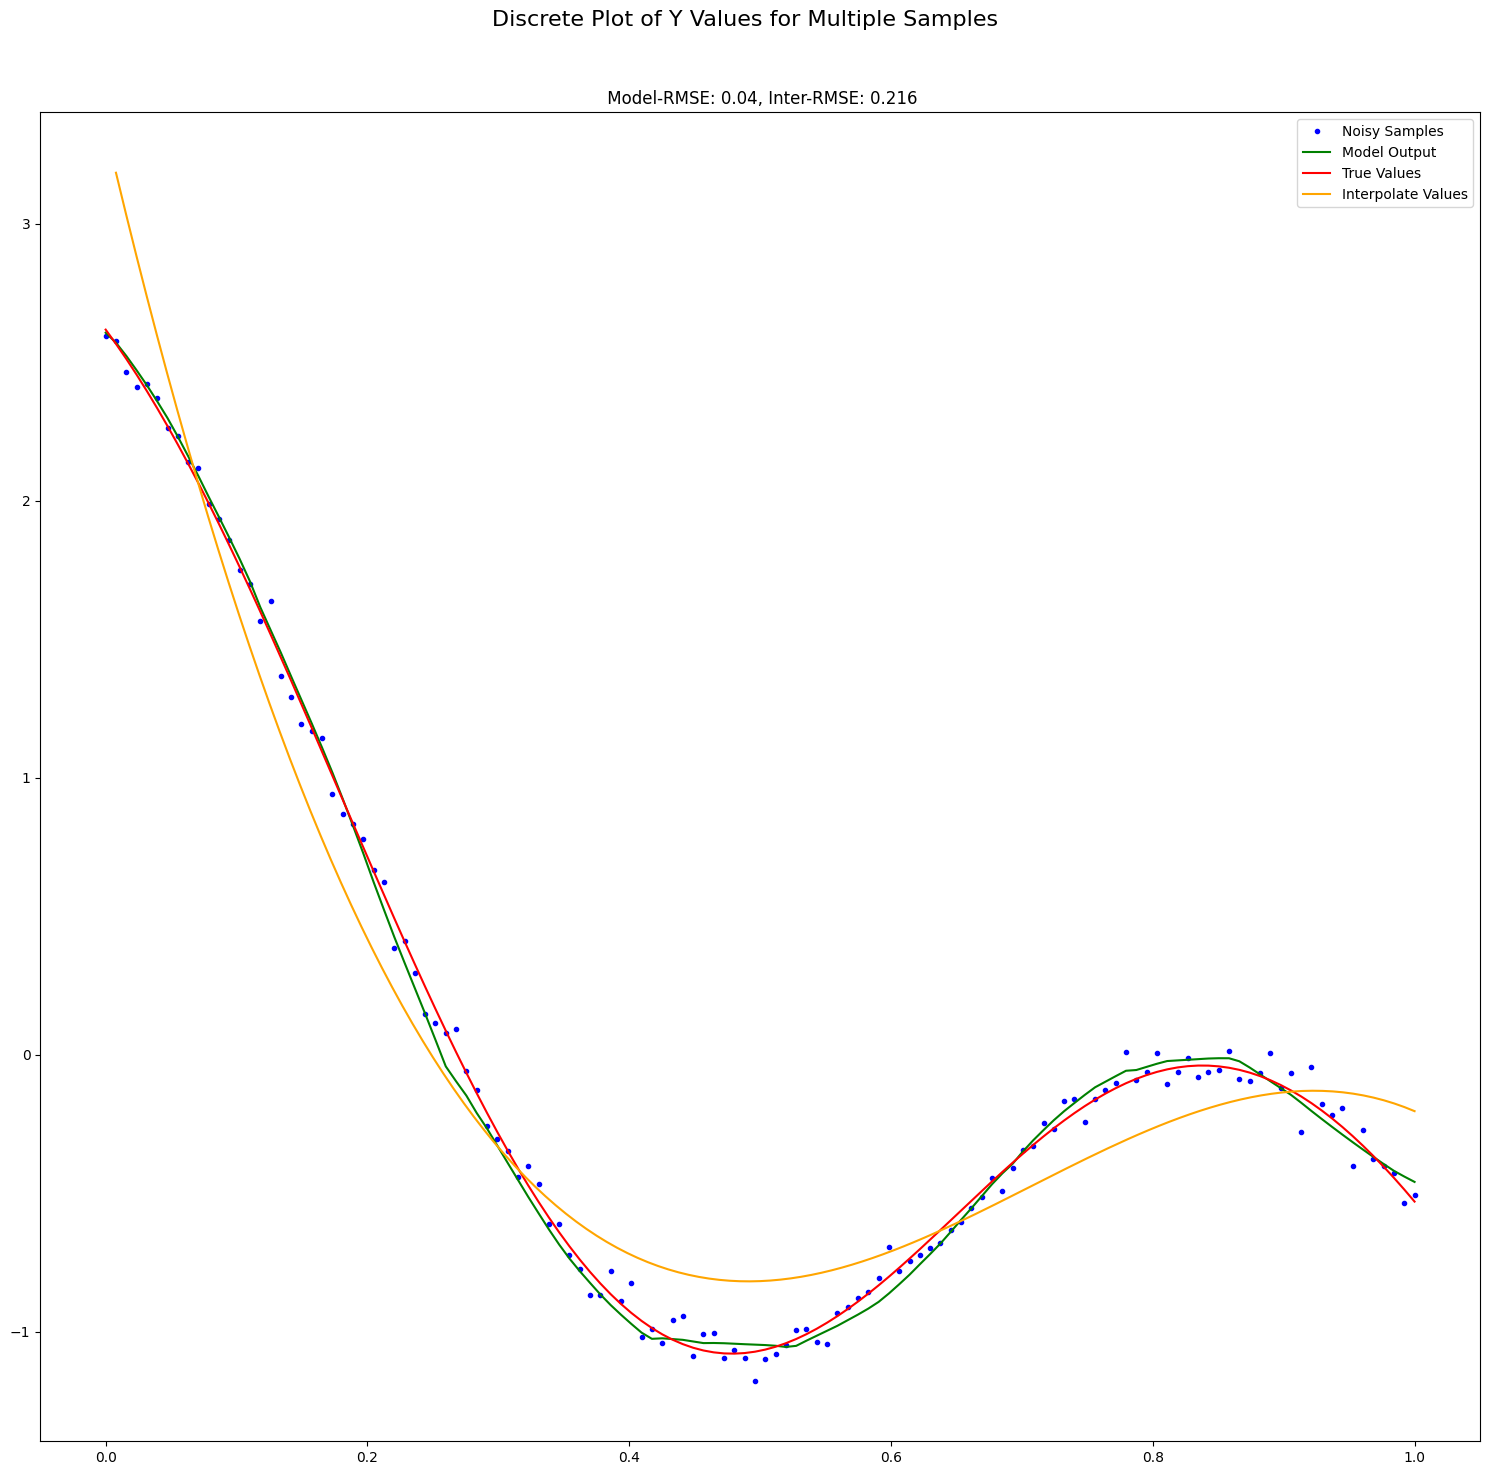

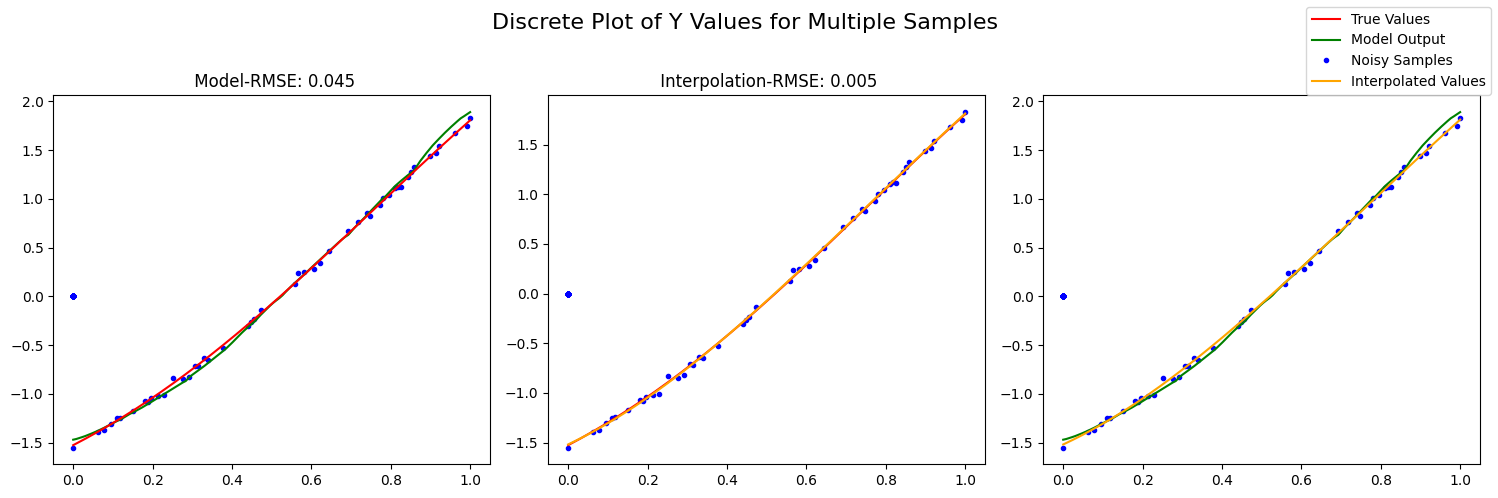

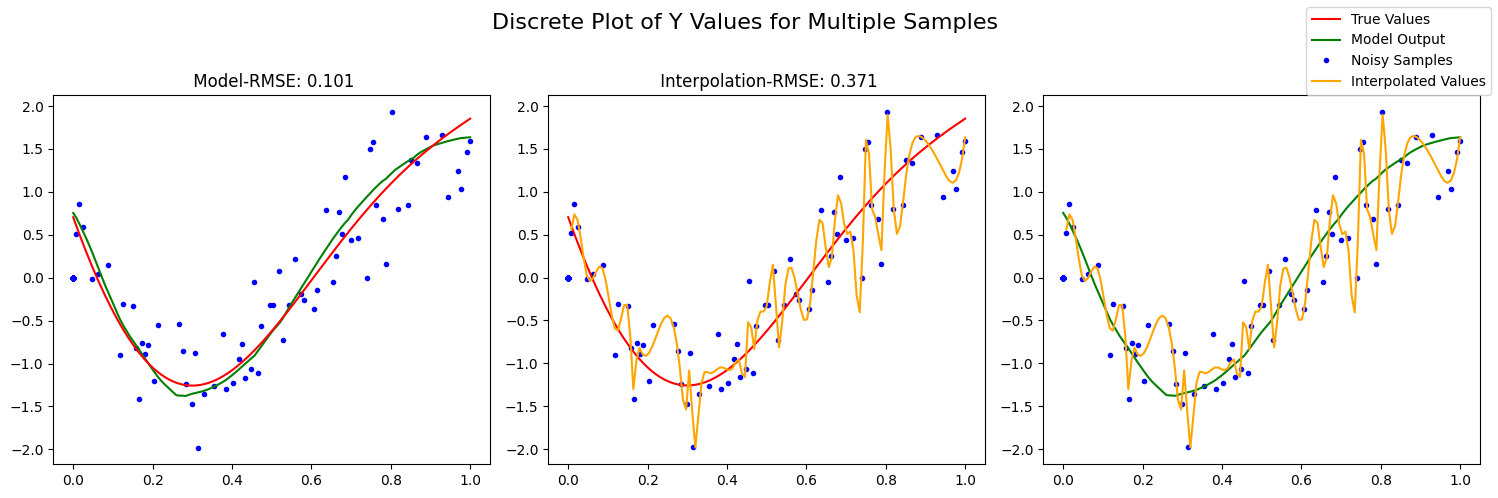

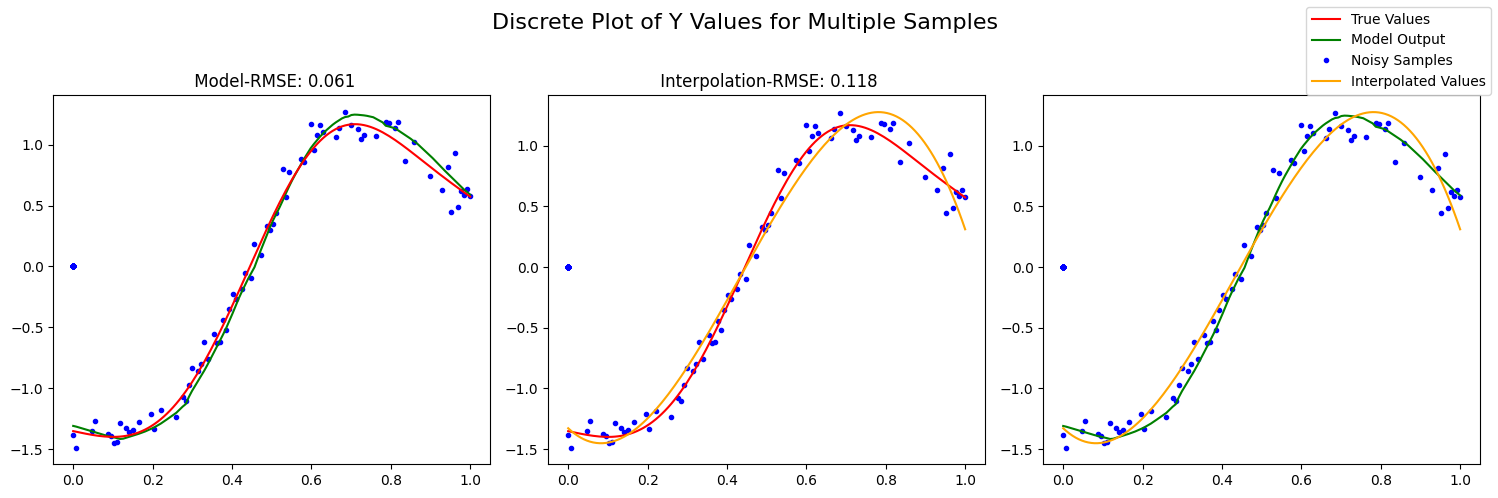

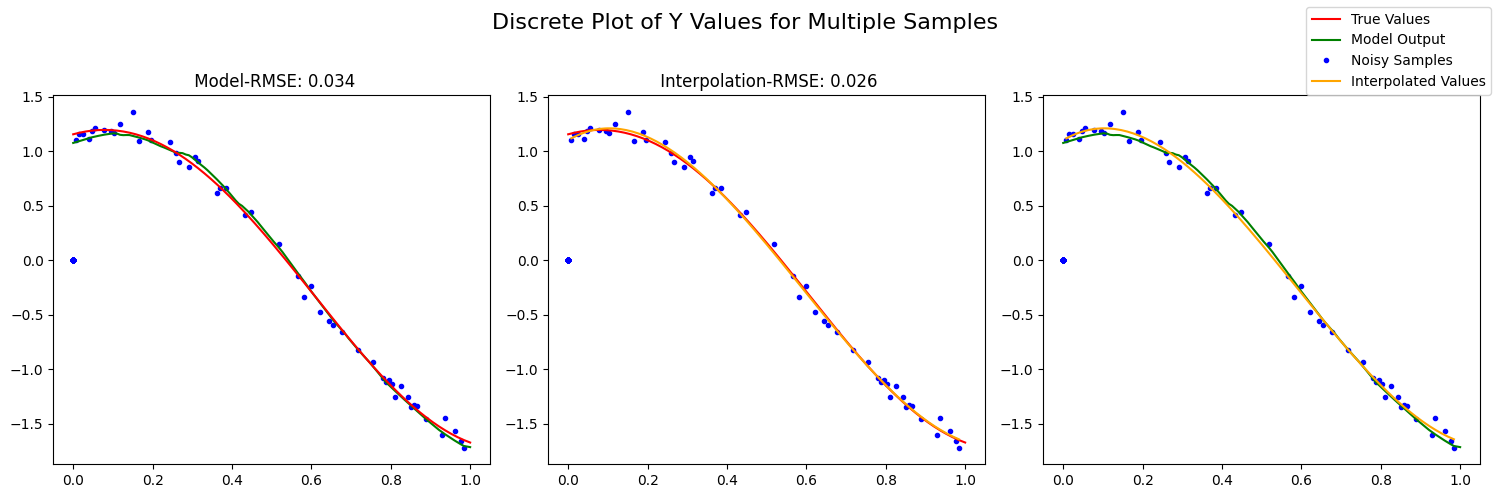

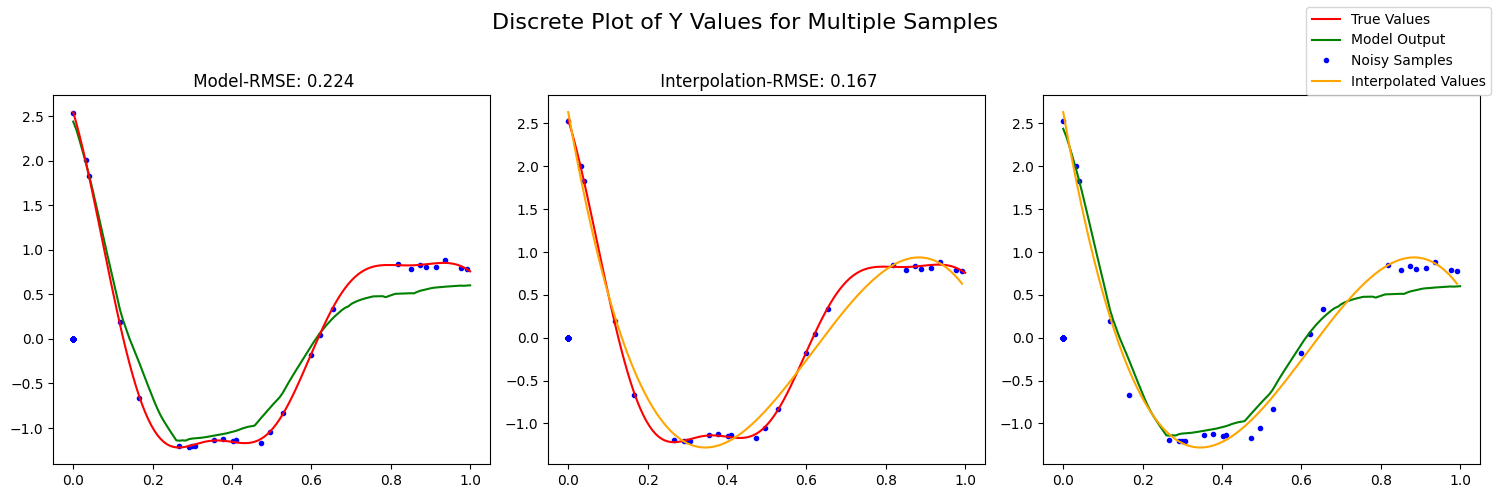

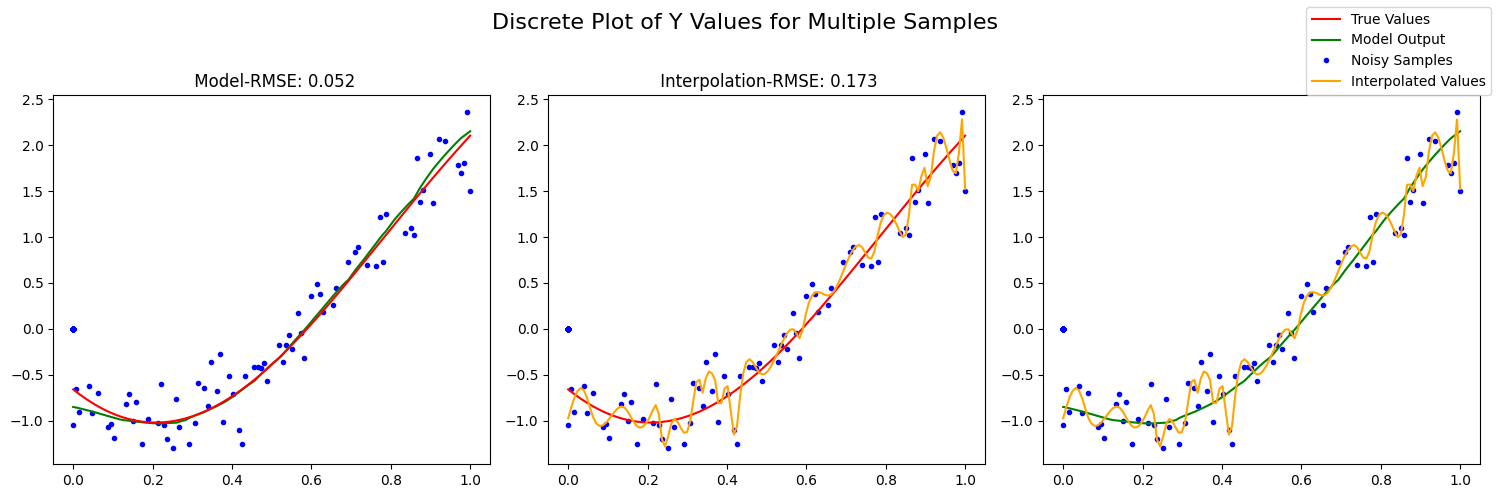

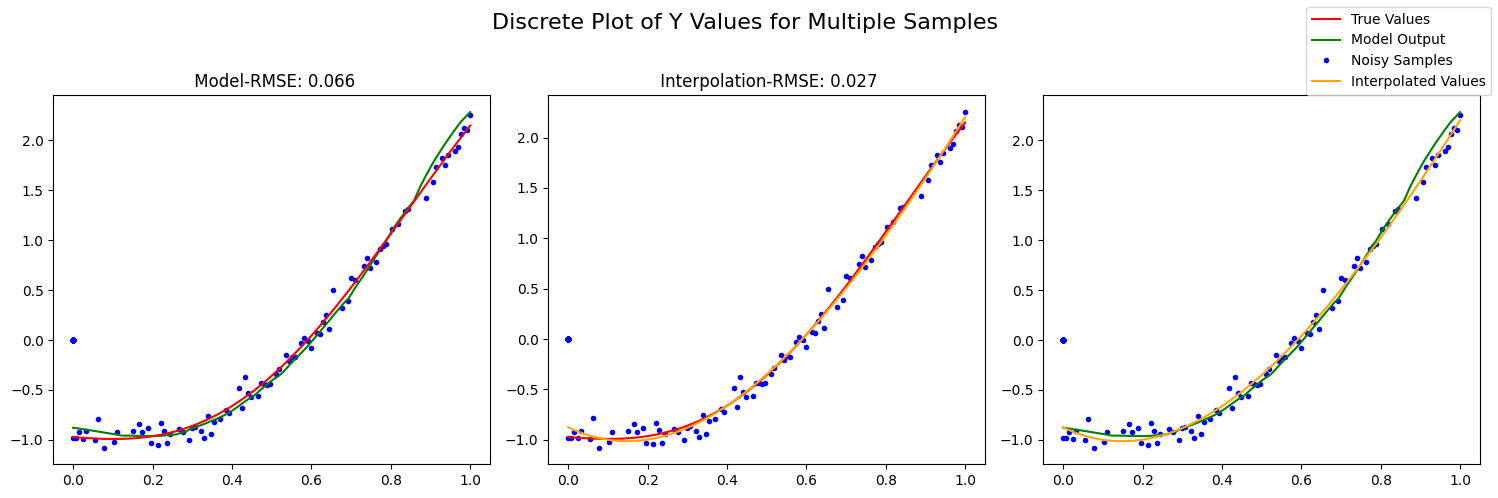

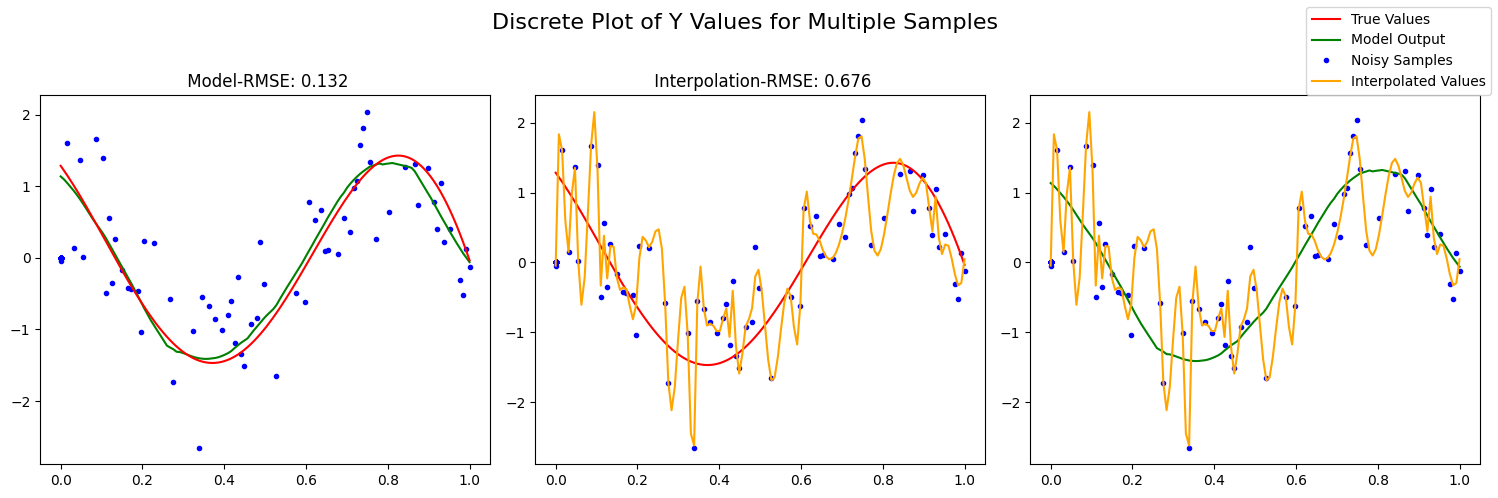

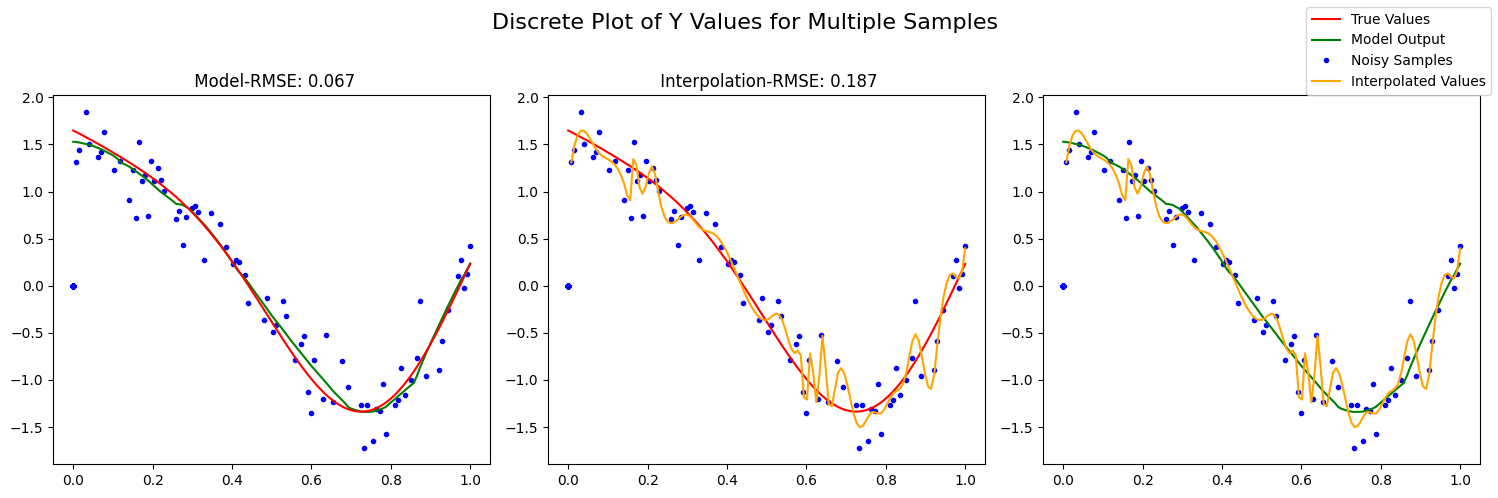

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.interpolate import UnivariateSpline
checkpoint = torch.load('./Jan/model_best.pth')
model = DeepONet(grid_size,d_model=256,heads=2,p=164)

# Restore model and optimizer state
model.load_state_dict(checkpoint)
model.to(device)
model.eval()


i =48
import matplotlib.pyplot as plt

for i in range(10):
    # Loop through each subplot (3x3 grid)
    # Create a 3x3 grid of subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle("Discrete Plot of Y Values for Multiple Samples", fontsize=16)
    for idx, ax in enumerate(np.array([axes]).flatten()):

        # Select the data for this subplot
        y_branch = torch.from_numpy(train_set_branch_y[i+idx].copy()).to(device).float().unsqueeze(0)
        t_branch = torch.from_numpy(train_set_branch_t[i+idx].copy()).to(device).float().unsqueeze(0)
        t_trunk = torch.from_numpy(train_set_trunk_t[i+idx].copy()).to(device).float().unsqueeze(0)
        branch_mask_ = torch.from_numpy(branch_mask[i+idx].copy()).to(device).float().unsqueeze(0)

        # Forward pass
        out = model(y_branch, t_branch, t_trunk, branch_mask_)
        
        # Prepare data for plotting
        y_values = samples_noisy[i+idx]
        real_values = samples[i+idx]
        truth = test_truth[i+idx]
    # print(y_values)
        x_inter, y_inter = interpolate(y_branch[0].cpu().numpy(),t_branch[0].cpu().numpy(),branch_mask_[0].cpu().numpy())

        # inter_rmse = np.sqrt(((interpolate - truth)**2).mean())
        model_rmse =np.sqrt(((out.cpu().detach().numpy() - truth)**2).mean())
        inter_rmse =np.sqrt(((y_inter - truth)**2).mean())
    # print(((out.cpu().detach().numpy() - truth)**2).mean())
        # Plot each series on the subplot
        axes[0].plot(t_branch.cpu().detach().numpy(), y_branch.cpu().detach().numpy(), color='blue',marker=".",linestyle="None")
        axes[0].plot(np.linspace(0,1,128), out.cpu().detach().numpy(), color='green')
        axes[0].plot(np.linspace(0,1,128), truth, color='red')
    # print(x_inter)
        #print(y_inter)

    # Forward pass
    out = model(y_branch, t_branch, t_trunk, branch_mask_)
    
    #Prepare data for plotting
    y_values = samples_noisy[i+idx]
    real_values = samples[i+idx]
    truth = test_truth[i+idx]
    #print(y_values)
    x_inter, y_inter = interpolate(y_branch[0].cpu().numpy(),t_branch[0].cpu().numpy(),branch_mask_[0].cpu().numpy())

    model_rmse =np.sqrt(((out.cpu().detach().numpy() - truth)**2).mean())
    inter_rmse =np.sqrt(((y_inter - truth)**2).mean())

    ax.plot(np.linspace(0,1,128), y_values, color='blue', label="Noisy Samples",marker=".",linestyle="None")
    ax.plot(np.linspace(0,1,128), out.cpu().detach().numpy(), color='green', label="Model Output")
    ax.plot(np.linspace(0,1,128), truth, color='red', label="True Values")

    ax.plot(x_inter, y_inter, color='orange', label="Interpolate Values")

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(f" Model-RMSE: {round(model_rmse,3)}, Inter-RMSE: {round(inter_rmse,3)}")
    #ax.grid(True)
    ax.legend()

    ground_truth_handle = mlines.Line2D([], [], color='red', label='True Values')
    prediction_handle = mlines.Line2D([], [], color='green', label='Model Output')
    observation_handle = mlines.Line2D([], [], color='blue', label='Noisy Samples', marker='.', linestyle='None')
    interpolation_handle = mlines.Line2D([], [], color='orange', label='Interpolated Values')

    fig.legend(handles=[ground_truth_handle, prediction_handle, observation_handle, interpolation_handle], loc='upper right',fontsize=10)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make space for the title
    plt.show()


0.11161291


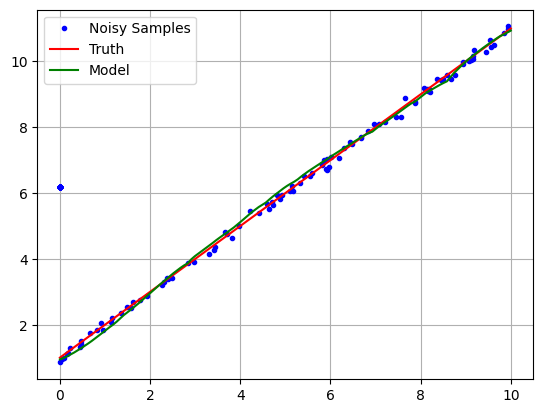

In [ ]:
import matplotlib.pyplot as plt
torch.save(model.state_dict(), "model_best.pth")
#checkpoint = torch.load('arwin.pth')
#model = DeepONet(grid_size,d_model=128,heads=2,p=128)

 #Restore model and optimizer state
#model.load_state_dict(checkpoint['model_state_dict'])
#model.to(device)
model.eval()
obs_grid = "0. 0.04588748 0.09159764 0.154311 0.18969745 0.23107812 0.44037433 0.46551259 0.4698422 0.47704967 0.66785167 0.81627236 0.90201521 0.95241703 1.12729778 1.14864347 1.36339895 1.49645256 1.58159458 1.61537626 1.7719714 1.92631915 2.2723072 2.30819694 2.36639828 2.39429573 2.49307768 2.83365748 2.97734284 3.30018475 3.42713179 3.44338513 3.67101318 3.70071144 3.82651719 3.96436809 4.21100116 4.4103133 4.5927691 4.6456428 4.70696965 4.73154 4.81327955 4.88203372 4.93375474 5.09674984 5.1514203 5.16924428 5.32374484 5.40409128 5.54255234 5.58893832 5.80597549 5.82208935 5.85903121 5.91029194 5.92191019 5.93088624 5.96112675 6.00609536 6.18001733 6.30389277 6.43150128 6.48084083 6.67812159 6.68206819 6.83963045 6.96922171 7.08483453 7.20008597 7.46360123 7.56433681 7.65297084 7.8679689 7.86873273 8.08294605 8.13605702 8.17417846 8.19601013 8.19857348 8.35981573 8.44979181 8.49774742 8.59409107 8.67625995 8.76494718 8.92907996 8.93134402 9.08121277 9.12686634 9.13060209 9.16862836 9.17055742 9.17844888 9.45820172 9.53187723 9.55631619 9.62251619 9.84111355 9.92931726 9.94418766".split()
obs_values = "0.85313171 0.94886456 0.9913655 1.12373941 1.1538541 1.28122004 1.32660459 1.49295406 1.42257618 1.39720176 1.73848647 1.82816094 2.04443918 1.83863094 2.07048476 2.21743274 2.36112713 2.53582418 2.50709211 2.69728738 2.75346224 2.86644065 3.2168426 3.30541183 3.40471169 3.4006658 3.41017454 3.87825226 3.90623223 4.14115363 4.2810781 4.36807786 4.80602395 4.77000786 4.64123313 5.01134075 5.4630334 5.39559734 5.65491826 5.51595296 5.72902836 5.65012075 5.92672484 5.81445033 5.94809901 6.07837817 6.21919096 6.06370414 6.31950136 6.52137031 6.52616659 6.61242782 6.87090184 6.84510611 6.99506471 6.72094563 7.039519 6.70756187 6.80345845 7.09894762 7.06580112 7.38326926 7.56279725 7.48480531 7.69555467 7.66979836 7.89036898 8.10229802 8.09277586 8.14774118 8.32538598 8.31605628 8.88322356 8.74041498 8.75358482 9.1787067 9.16509112 9.11234973 9.16522074 9.08388677 9.45401259 9.43567678 9.47647436 9.59452738 9.47847781 9.5957691 9.99459821 9.92405368 10.0093065 10.05398787 10.0765146 10.08835275 10.17442852 10.33270049 10.28733318 10.64823178 10.43109297 10.50999956 10.87251012 10.98692423 11.06202351".split()
evaluation_grid = "0. 0.07874016 0.15748031 0.23622047 0.31496063 0.39370079 0.47244094 0.5511811 0.62992126 0.70866142 0.78740157 0.86614173 0.94488189 1.02362205 1.1023622 1.18110236 1.25984252 1.33858268 1.41732283 1.49606299 1.57480315 1.65354331 1.73228346 1.81102362 1.88976378 1.96850394 2.04724409 2.12598425 2.20472441 2.28346457 2.36220472 2.44094488 2.51968504 2.5984252 2.67716535 2.75590551 2.83464567 2.91338583 2.99212598 3.07086614 3.1496063 3.22834646 3.30708661 3.38582677 3.46456693 3.54330709 3.62204724 3.7007874 3.77952756 3.85826772 3.93700787 4.01574803 4.09448819 4.17322835 4.2519685 4.33070866 4.40944882 4.48818898 4.56692913 4.64566929 4.72440945 4.80314961 4.88188976 4.96062992 5.03937008 5.11811024 5.19685039 5.27559055 5.35433071 5.43307087 5.51181102 5.59055118 5.66929134 5.7480315 5.82677165 5.90551181 5.98425197 6.06299213 6.14173228 6.22047244 6.2992126 6.37795276 6.45669291 6.53543307 6.61417323 6.69291339 6.77165354 6.8503937 6.92913386 7.00787402 7.08661417 7.16535433 7.24409449 7.32283465 7.4015748 7.48031496 7.55905512 7.63779528 7.71653543 7.79527559 7.87401575 7.95275591 8.03149606 8.11023622 8.18897638 8.26771654 8.34645669 8.42519685 8.50393701 8.58267717 8.66141732 8.74015748 8.81889764 8.8976378 8.97637795 9.05511811 9.13385827 9.21259843 9.29133858 9.37007874 9.4488189 9.52755906 9.60629921 9.68503937 9.76377953 9.84251969 9.92125984 10.".split()
evaluation_values = "1. 1.07874016 1.15748031 1.23622047 1.31496063 1.39370079 1.47244094 1.5511811 1.62992126 1.70866142 1.78740157 1.86614173 1.94488189 2.02362205 2.1023622 2.18110236 2.25984252 2.33858268 2.41732283 2.49606299 2.57480315 2.65354331 2.73228346 2.81102362 2.88976378 2.96850394 3.04724409 3.12598425 3.20472441 3.28346457 3.36220472 3.44094488 3.51968504 3.5984252 3.67716535 3.75590551 3.83464567 3.91338583 3.99212598 4.07086614 4.1496063 4.22834646 4.30708661 4.38582677 4.46456693 4.54330709 4.62204724 4.7007874 4.77952756 4.85826772 4.93700787 5.01574803 5.09448819 5.17322835 5.2519685 5.33070866 5.40944882 5.48818898 5.56692913 5.64566929 5.72440945 5.80314961 5.88188976 5.96062992 6.03937008 6.11811024 6.19685039 6.27559055 6.35433071 6.43307087 6.51181102 6.59055118 6.66929134 6.7480315 6.82677165 6.90551181 6.98425197 7.06299213 7.14173228 7.22047244 7.2992126 7.37795276 7.45669291 7.53543307 7.61417323 7.69291339 7.77165354 7.8503937 7.92913386 8.00787402 8.08661417 8.16535433 8.24409449 8.32283465 8.4015748 8.48031496 8.55905512 8.63779528 8.71653543 8.79527559 8.87401575 8.95275591 9.03149606 9.11023622 9.18897638 9.26771654 9.34645669 9.42519685 9.50393701 9.58267717 9.66141732 9.74015748 9.81889764 9.8976378 9.97637795 10.05511811 10.13385827 10.21259843 10.29133858 10.37007874 10.4488189 10.52755906 10.60629921 10.68503937 10.76377953 10.84251969 10.92125984 11.".split()
obs_grid = np.array(obs_grid, dtype=float)
obs_values = np.array(obs_values, dtype=float)
evaluation_grid = np.array(evaluation_grid, dtype=float)
evaluation_values = np.array(evaluation_values, dtype=float)


obs_values_mean,obs_values_std  =obs_values.mean(), obs_values.std()
evaluation_values_mean, evaluation_values_std  =evaluation_values.mean(), evaluation_values.std()


#obs_values = (obs_values - min_values) / (max_values-min_values) 
#evaluation_values = (evaluation_values - min_values) / (max_values - min_values)

obs_values = (obs_values - obs_values.mean()) / (obs_values.std()) 
evaluation_values = (evaluation_values - evaluation_values.mean()) / (evaluation_values.std())


min_grid  = min(obs_grid.min(), evaluation_grid.min())
max_grid  = max(obs_grid.max(), evaluation_grid.max())

#obs_grid = (obs_grid - min_grid) / (max_grid-min_grid) 
#evaluation_grid = (evaluation_grid - min_grid) / (max_grid-min_grid) 

obs_grid = (obs_grid - min_grid) / (max_grid-min_grid)
evaluation_grid = (evaluation_grid - min_grid) / (max_grid-min_grid)


mask = np.append(np.ones(len(obs_grid)),np.zeros(len(evaluation_grid)-len(obs_grid)))
obs_grid = np.append(obs_grid,np.zeros(len(evaluation_grid)-len(obs_grid)))
obs_values = np.append(obs_values,np.zeros(len(evaluation_grid)-len(obs_values)))

mask = torch.from_numpy(mask).to(device).unsqueeze(0).float()

obs_grid = torch.from_numpy(obs_grid).to(device).unsqueeze(0).float()
obs_values = torch.from_numpy(obs_values).to(device).unsqueeze(0).float()
evaluation_grid = torch.from_numpy(evaluation_grid).to(device).unsqueeze(0).float()
evaluation_values = torch.from_numpy(evaluation_values).to(device).unsqueeze(0).float()


out = model(obs_values, obs_grid, evaluation_grid, mask)

obs_grid = obs_grid.squeeze(0).cpu().numpy() * (max_grid-min_grid) + min_grid
obs_values = obs_values.squeeze(0).cpu().numpy() * obs_values_std + obs_values_mean 
evaluation_grid = (evaluation_grid.squeeze(0).cpu().numpy()) * (max_grid-min_grid) + min_grid
evaluation_values = evaluation_values.squeeze(0).cpu().numpy()  * evaluation_values_std + evaluation_values_mean 

out = out.cpu().detach().numpy() * evaluation_values_std + evaluation_values_mean 




print(np.sqrt(((out - evaluation_values)**2).mean()))



plt.plot(obs_grid, obs_values, color='blue', label="Noisy Samples",marker=".",linestyle="None")
plt.plot(evaluation_grid, evaluation_values, color='red', label="Truth")
plt.plot(evaluation_grid, out, color='green', label="Model")

plt.grid(True)
plt.legend()



#

In [ ]:
import matplotlib.pyplot as plt

grid = 128
y = np.array([])
t = np.array([])
truth = np.array(grid)
x = np.linspace(0,1,grid)
mask = np.append(np.ones(len(y)),np.zeros(grid-len(y)))


y = torch.from_numpy(y).to(device).unsqueeze(0)
t = torch.from_numpy(t).to(device).unsqueeze(0)
truth = torch.from_numpy(truth).to(device).unsqueeze(0)
x = torch.from_numpy(x).to(device).unsqueeze(0)
mask = torch.from_numpy(mask).to(device).unsqueeze(0)


checkpoint = torch.load('model.pth')
model = DeepONet(grid_size,d_model=256,heads=2,p=164)

# Restore model and optimizer state
model.load_state_dict(checkpoint)
model.to(device)


out = model(y, t, x, mask)

model_rmse =np.sqrt(((out - truth)**2).mean())

plt.plot(range(len(x)), truth, color='red', label="Truth")
plt.plot(range(len(x)), out, color='green', label="Model Pred")

plt.set_xlabel("Index")
plt.set_ylabel("Y Values")
plt.set_title(f" Model-RMSE: {round(model_rmse,3)}")
plt.grid(True)
plt.legend()





RuntimeError: The size of tensor a (0) must match the size of tensor b (128) at non-singleton dimension 1